#Análise de Evasão de Clientes – Telecom X

## 1. Introdução

A Telecom X, operadora de serviços de telecomunicações, enfrenta atualmente um elevado índice de cancelamentos de contratos por parte de seus clientes. Esse fenômeno, conhecido como churn, representa um dos principais desafios para empresas do setor, impactando diretamente na receita recorrente e na sustentabilidade do negócio.

Diante desse cenário, este trabalho tem como objetivo realizar uma análise exploratória dos dados dos clientes, a fim de identificar os principais fatores que contribuem para a evasão. Por meio da coleta, tratamento e análise dos dados, busca-se compreender o perfil dos clientes que mais cancelam os serviços e quais características estão associadas a esse comportamento.

Ao longo desta análise, serão abordados aspectos como o tipo de contrato, os métodos de pagamento, os valores cobrados, além do tempo de permanência dos clientes na empresa. Esses insights são fundamentais para subsidiar a criação de estratégias de retenção, melhoria dos serviços e desenvolvimento de modelos preditivos que antecipem comportamentos de cancelamento.

Este estudo representa um passo inicial e crucial no desenvolvimento de uma abordagem orientada a dados, capaz de gerar valor e apoiar a tomada de decisão na Telecom X.

##2. Descrição da leitura e modificações da base de dados

Aqui faremos a leitura, manipulação, limpeza e tradução da base de dados para facilitar a visualização. A partir disso, levantaremos os dados-chaves para guiar nossa análise.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
df = pd.read_json(url)

In [111]:
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [112]:
for coluna in df.columns:
    if isinstance(df[coluna][0], dict):
        # Expandir a coluna
        col_expandida = df[coluna].apply(pd.Series)
        # Renomear colunas para evitar conflitos
        col_expandida.columns = [f"{coluna}_{subcol}" for subcol in col_expandida.columns]
        # Concatenar no dataframe
        df = pd.concat([df.drop(columns=[coluna]), col_expandida], axis=1)


In [113]:
df.head()

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,"{'Monthly': 65.6, 'Total': '593.3'}"
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,"{'Monthly': 59.9, 'Total': '542.4'}"
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,"{'Monthly': 73.9, 'Total': '280.85'}"
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,"{'Monthly': 98.0, 'Total': '1237.85'}"
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,"{'Monthly': 83.9, 'Total': '267.4'}"


Percebemos aqui que a coluna "account_Charges" ainda se encontra aninhada em cobrança mensal e total, e somos proposto o desafio de criar uma coluna diária. Portanto, separaremos os dados em três novas colunas: diária, mensal e anual.

In [114]:
# Expandir a coluna 'account_Charges' e criar 'Contas_Diarias' em uma etapa organizada

# Separar e transformar a coluna de cobranças
df[['account_charges_Monthly', 'account_charges_Total']] = df['account_Charges'].apply(pd.Series)

# Converter 'account_charges_Total' para numérico, se vier como string
df['account_charges_Total'] = pd.to_numeric(df['account_charges_Total'], errors='coerce')

# Criar a coluna 'Contas_Diarias'
df['Contas_Diarias'] = df['account_charges_Monthly'] / 30

# Remover a coluna original aninhada
df = df.drop(columns=['account_Charges'])

# Reordenar
colunas = list(df.columns)
colunas.remove('Contas_Diarias')
colunas.insert(len(colunas) - 2, 'Contas_Diarias')
df = df[colunas]



In [115]:
df.head()

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,Contas_Diarias,account_charges_Monthly,account_charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,2.186667,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,1.996667,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,2.463333,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,3.266667,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,2.796667,83.9,267.40


In [116]:
#Arredondar a coluna para representar um valor financeiro verdadeiro
df['Contas_Diarias'] = df['Contas_Diarias'].round(2)

Nesse momento percebemos que existiam clientes na base de dados que estavam com o Churn nulo. Como faremos desta métrica a central para a análise, optamos por remover estes clientes e trabalhar em cima de uma nova base de dados filtrada.

In [117]:
#Remove os clientes sem taxa de Churn
df = df[df['Churn'].str.strip() != '']

# Verificar linhas duplicadas
df.duplicated().sum()

# Se houver, podemos remover:
df = df.drop_duplicates()

Aqui fizemos a padroniação da database para melhor visualização e tradução dos termos.

*Não vimos utilidade em transformar o boleano de Churn em 0 ou 1 neste caso, nos permitindo fazer a contagem como "sim" ou "não" e piorando a visualização dos dados, portanto somente traduzimos esta informação.

In [118]:
# ✅ Copia do dataframe original para segurança
df_padronizado = df.copy()

# 🔸 Converter 'Churn' para binário
df_padronizado['Churn'] = df_padronizado['Churn'].map({'Yes': 'Sim', 'No': "Não"})

# 🔸 Converter colunas de características binárias
colunas_binarias = [
    'customer_Partner', 'customer_Dependents',
    'phone_PhoneService', 'phone_MultipleLines',
    'internet_OnlineSecurity', 'internet_OnlineBackup',
    'internet_DeviceProtection', 'internet_TechSupport',
    'internet_StreamingTV', 'internet_StreamingMovies',
    'account_PaperlessBilling'
]

for coluna in colunas_binarias:
    df_padronizado[coluna] = df_padronizado[coluna].map({'Yes': 'Sim', 'No': 'Não'})

# 🔸 Traduzir categorias
df_padronizado['account_Contract'] = df_padronizado['account_Contract'].replace({
    'Month-to-month': 'Mensal',
    'One year': 'Anual',
    'Two year': 'Bienal'
})

df_padronizado['account_PaymentMethod'] = df_padronizado['account_PaymentMethod'].replace({
    'Bank transfer (automatic)': 'Transferência Bancária (Automática)',
    'Credit card (automatic)': 'Cartão de Crédito (Automático)',
    'Electronic check': 'Boleto Eletrônico',
    'Mailed check': 'Boleto Correios'
})

df_padronizado['internet_InternetService'] = df_padronizado['internet_InternetService'].replace({
    'DSL': 'DSL',
    'Fiber optic': 'Fibra Óptica',
    'No': 'Sem Internet'
})

# 🔸 Padronizar nome das colunas (opcional, mas recomendado)
df_padronizado = df_padronizado.rename(columns={
    'customerID': 'ID_Cliente',
    'customer_gender': 'Genero',
    'customer_SeniorCitizen': 'Idoso',
    'customer_Partner': 'Possui_Parceiro',
    'customer_Dependents': 'Possui_Dependentes',
    'customer_tenure': 'Tempo_Cliente_Meses',
    'phone_PhoneService': 'Telefone_Ativo',
    'phone_MultipleLines': 'Multiplas_Linhas',
    'internet_InternetService': 'Tipo_Internet',
    'internet_OnlineSecurity': 'Seguranca_Online',
    'internet_OnlineBackup': 'Backup_Online',
    'internet_DeviceProtection': 'Protecao_Dispositivo',
    'internet_TechSupport': 'Suporte_Tecnico',
    'internet_StreamingTV': 'Streaming_TV',
    'internet_StreamingMovies': 'Streaming_Filmes',
    'account_Contract': 'Tipo_Contrato',
    'account_PaperlessBilling': 'Fatura_Papel',
    'account_PaymentMethod': 'Metodo_Pagamento',
    'account_charges_Monthly': 'Cobranca_Mensal',
    'account_charges_Total': 'Cobranca_Total',
    'Contas_Diarias': 'Cobranca_Diaria'
})


Explicamos o porque desta limpeza futuramente no trabalho:

In [119]:
df_padronizado = df_padronizado[df_padronizado['Tempo_Cliente_Meses'] > 0]


In [120]:
 df_padronizado.columns.values

array(['ID_Cliente', 'Churn', 'Genero', 'Idoso', 'Possui_Parceiro',
       'Possui_Dependentes', 'Tempo_Cliente_Meses', 'Telefone_Ativo',
       'Multiplas_Linhas', 'Tipo_Internet', 'Seguranca_Online',
       'Backup_Online', 'Protecao_Dispositivo', 'Suporte_Tecnico',
       'Streaming_TV', 'Streaming_Filmes', 'Tipo_Contrato',
       'Fatura_Papel', 'Metodo_Pagamento', 'Cobranca_Diaria',
       'Cobranca_Mensal', 'Cobranca_Total'], dtype=object)

Sendo assim, as colunas mais importantes para a análise de evasão da empresa TelecomX são:


*  Churn: Indica se o cliente cancelou o serviço durante um período específico;
*  Tipo_Internet: o tipo de internet que o cliente contrata pode explicar a experiência que levou ao cancelamento;
*  Tipo_Contrato: o tipo de contratado provavelmente tem um índice, é provável que vamos encontrar que as assinaturas mensais tem uma taxa de cancelamento maior;
*  Metodo_Pagamento: é possível que o tipo de pagamento esteja relacionado com o índice de cancelamento;
*   Tempo_Cliente_Meses: clientes de longa data devem cancelar numa proporção menor que clientes novos;
* Cobrança Diária/Mensal/Total: Investigaremos se há uma discrepância de cobrança entre clientes que possa justificar/orientar as possíveis medidas a se tomar pela empresa.








## 3. Cruzamento de dados e Análise Descritiva

Faremos então o cruzamento de dados, tendo como central a taxa de Churn, com gráficos relevantes para a representação do recorte feito.


In [121]:
df_contrato_churn = df_padronizado.groupby(['Tipo_Contrato', 'Churn']).size().reset_index(name='contagem')

df_contrato_churn


,Tipo_Contrato,Churn,contagem
0,Anual,Não,1306
1,Anual,Sim,166
2,Bienal,Não,1637
3,Bienal,Sim,48
4,Mensal,Não,2220
5,Mensal,Sim,1655


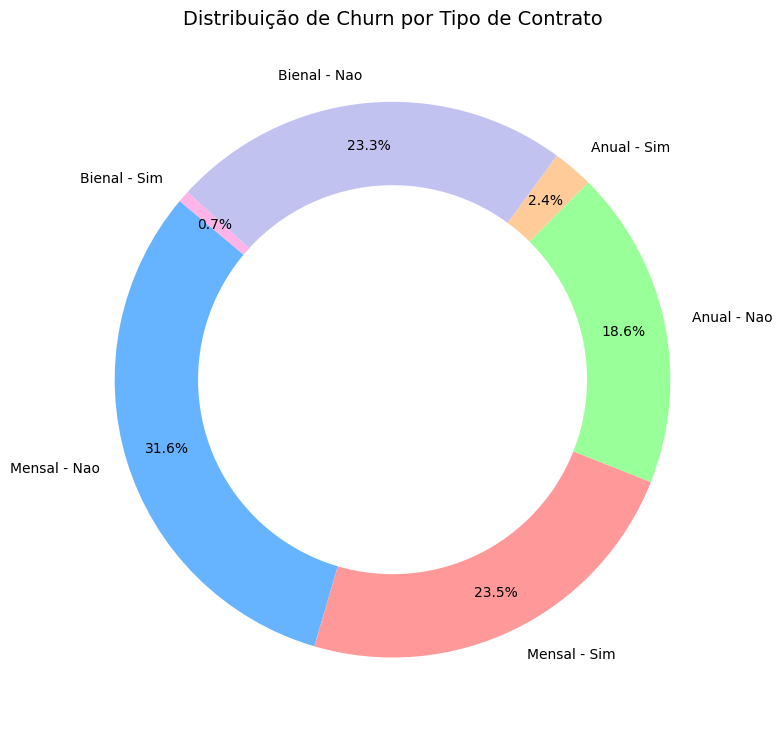

In [122]:
# Dados
labels = [
    'Mensal - Nao', 'Mensal - Sim',
    'Anual - Nao', 'Anual - Sim',
    'Bienal - Nao', 'Bienal - Sim'
]

sizes = [2220, 1655, 1306, 166, 1637, 48]

# Cores diferenciando 'No' e 'Yes'
colors = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

# Plot
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140, pctdistance=0.85)

# Centralizar um círculo branco no meio (donut)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Distribuição de Churn por Tipo de Contrato', fontsize=14)
plt.tight_layout()
plt.show()


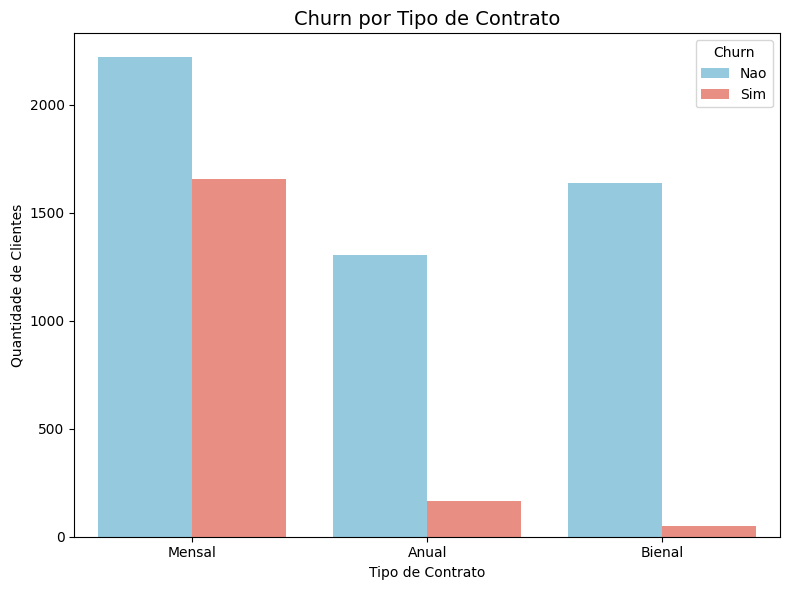

In [123]:
# Dados
data = {
    'Tipo_Contrato': ['Mensal', 'Mensal', 'Anual', 'Anual', 'Bienal', 'Bienal'],
    'churn': ['Nao', 'Sim', 'Nao', 'Sim', 'Nao', 'Sim'],
    'contagem': [2220, 1655, 1306, 166, 1637, 48]
}

df_contrato_churn = pd.DataFrame(data)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    data=df_contrato_churn,
    x='Tipo_Contrato',
    y='contagem',
    hue='churn',
    palette={'Nao': 'skyblue', 'Sim': 'salmon'}
)

plt.title('Churn por Tipo de Contrato', fontsize=14)
plt.xlabel('Tipo de Contrato')
plt.ylabel('Quantidade de Clientes')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()


##3.1. Taxa de Churn por Tipo de Contrato
🔸 Clientes Mensais:
Apresentam a maior taxa de churn, 42.7%, indicando alta flexibilidade no cancelamento. É típico em contratos sem fidelidade, onde o cliente pode sair a qualquer momento.

🔸 Clientes Anuais:
A taxa é bem menor, 11.3%, o que sugere que o compromisso anual ajuda na retenção, seja por barreiras contratuais ou percepção de maior valor.

🔸 Clientes Bienais:
Possuem a menor taxa de churn, 2.8%, demonstrando altíssima retenção. Isso é esperado, pois quem opta por dois anos geralmente já tem maior confiança na empresa.

Esses dados reforçam que contratos mais longos são altamente eficientes para retenção de clientes, criando barreiras para o churn.
No entanto, não explicam diretamente as causas do cancelamento. Isso exige análise de outros fatores, como qualidade dos serviços (internet, suporte, telefone), problemas técnicos ou questões financeiras (valores de cobrança).





In [124]:
df_tenure = df_padronizado.groupby(['Churn']).agg({
    'Tempo_Cliente_Meses': ['mean', 'median', 'min', 'max']
}).reset_index()

print(df_tenure)

  Churn Tempo_Cliente_Meses               
                       mean median min max
0   Não           37.650010   38.0   1  72
1   Sim           17.979133   10.0   1  72


<ipython-input-125-159fc5188fc8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_padronizado, x='Churn', y='Tempo_Cliente_Meses', palette={'Não':'skyblue', 'Sim':'salmon'})


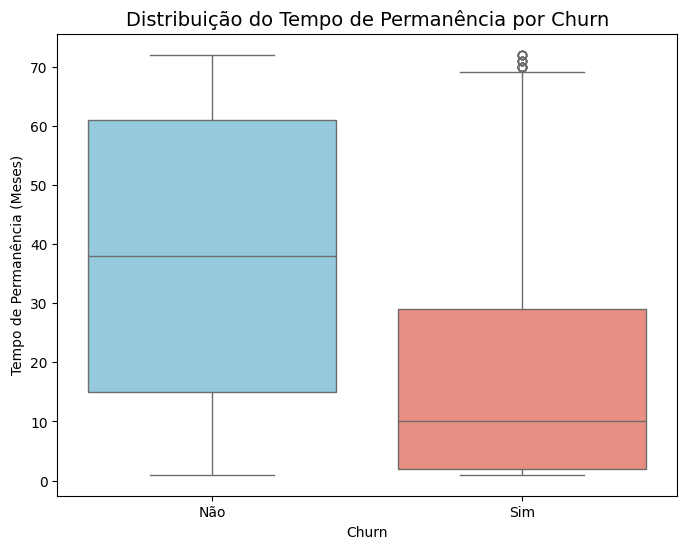

In [125]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df_padronizado, x='Churn', y='Tempo_Cliente_Meses', palette={'Não':'skyblue', 'Sim':'salmon'})

plt.title('Distribuição do Tempo de Permanência por Churn', fontsize=14)
plt.xlabel('Churn')
plt.ylabel('Tempo de Permanência (Meses)')
plt.show()

##3.2. Taxa de Churn por Permanência

A maior parte dos clientes que cancelam fazem isso nos primeiros meses de contrato, especialmente antes de completar 10 meses, como demonstra a mediana dos gráficos Boxplot. Quem passa dessa faixa tende a permanecer muito mais tempo na empresa.

In [126]:
df_pagamento_churn = df_padronizado.groupby(['Metodo_Pagamento', 'Churn']).size().reset_index(name='contagem')

print(df_pagamento_churn)

                      Metodo_Pagamento Churn  contagem
0                      Boleto Correios   Não      1296
1                      Boleto Correios   Sim       308
2                    Boleto Eletrônico   Não      1294
3                    Boleto Eletrônico   Sim      1071
4       Cartão de Crédito (Automático)   Não      1289
5       Cartão de Crédito (Automático)   Sim       232
6  Transferência Bancária (Automática)   Não      1284
7  Transferência Bancária (Automática)   Sim       258


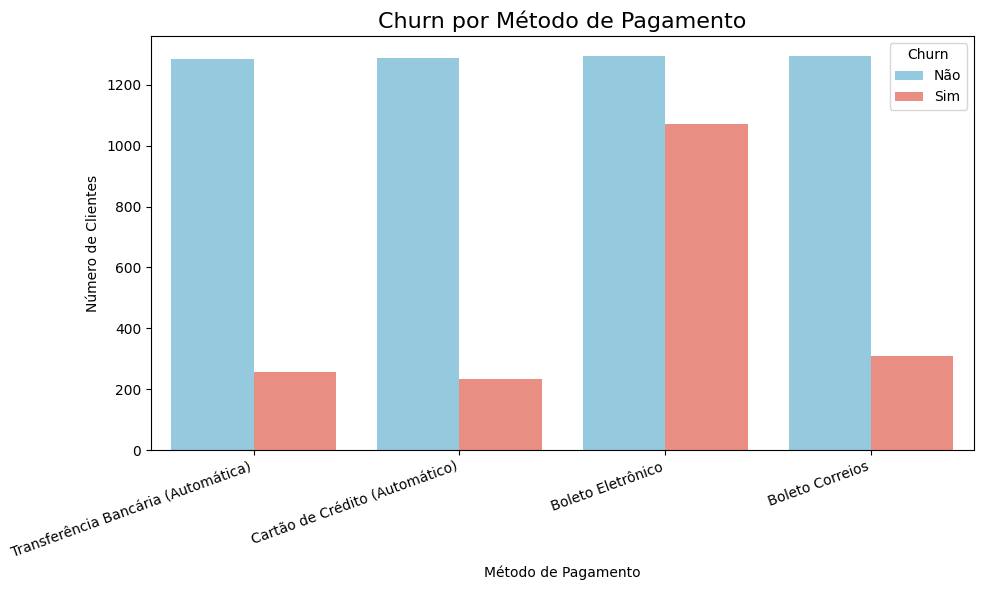

In [127]:
data = {
    'Metodo_Pagamento': [
        'Transferência Bancária (Automática)', 'Transferência Bancária (Automática)',
        'Cartão de Crédito (Automático)', 'Cartão de Crédito (Automático)',
        'Boleto Eletrônico', 'Boleto Eletrônico',
        'Boleto Correios', 'Boleto Correios'
    ],
    'Churn': ['Não', 'Sim', 'Não', 'Sim', 'Não', 'Sim', 'Não', 'Sim'],
    'Count': [1284, 258, 1289, 232, 1294, 1071, 1296, 308]
}

df_pagamento_churn = pd.DataFrame(data)

# Gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_pagamento_churn,
    x='Metodo_Pagamento',
    y='Count',
    hue='Churn',
    palette={'Não':'skyblue', 'Sim':'salmon'}
)

plt.title('Churn por Método de Pagamento', fontsize=16)
plt.xlabel('Método de Pagamento')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=20, ha='right')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()
#

##3.4. Taxa de Churn por Metódo de Pagamento

O método de pagamento boleto eletrônico tem disparado a maior taxa de churn (45.3%), muito acima dos outros métodos.
Esse método normalmente está associado a pagamentos manuais, com maior facilidade de cancelamento ou não renovação.

Métodos automáticos como transferência bancária e cartão de crédito, ambos automáticos, possuem as menores taxas de churn (16.7% e 15.2%, respectivamente).
Isso sugere que automação no pagamento está fortemente associada à retenção de clientes.

Boleto Correios apresenta uma taxa intermediária de churn (19.1%), menor que o boleto eletrônico, mas ainda acima dos métodos automáticos.

A empresa deve incentivar os clientes a migrarem para métodos de pagamento automáticos (débito automático ou cartão), visto que há uma clara correlação entre churn mais baixo e automação no pagamento.

In [128]:
# Agrupar os dados por 'Churn' e calcular estatísticas descritivas
resumo_financeiro = df_padronizado.groupby('Churn')[['Cobranca_Diaria', 'Cobranca_Mensal']].agg(
    ['mean', 'median', 'min', 'max']
).round(2)

# Exibir o resumo
print(resumo_financeiro)


      Cobranca_Diaria                    Cobranca_Mensal                      
                 mean median   min   max            mean median    min     max
Churn                                                                         
Não              2.04   2.15  0.61  3.96           61.31  64.45  18.25  118.75
Sim              2.48   2.66  0.63  3.94           74.44  79.65  18.85  118.35


<ipython-input-129-bbecc44b81ce>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_padronizado, x='Churn', y='Cobranca_Mensal', ax=axs[0],palette='Set2')
<ipython-input-129-bbecc44b81ce>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_padronizado, x='Churn', y='Cobranca_Diaria', ax=axs[1], palette='Set3')


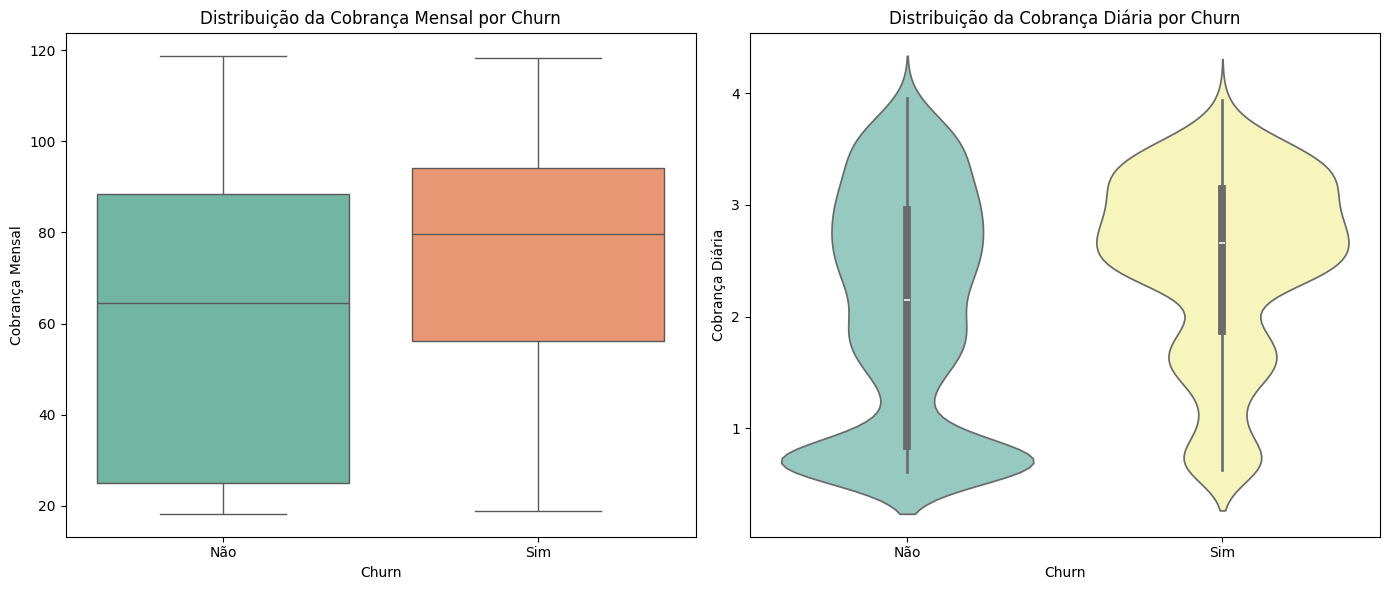

In [129]:
# Configurar o layout dos gráficos lado a lado
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot da cobrança mensal
sns.boxplot(data=df_padronizado, x='Churn', y='Cobranca_Mensal', ax=axs[0],palette='Set2')
axs[0].set_title('Distribuição da Cobrança Mensal por Churn')
axs[0].set_xlabel('Churn')
axs[0].set_ylabel('Cobrança Mensal')

# Gráfico de violino da cobrança diária
sns.violinplot(data=df_padronizado, x='Churn', y='Cobranca_Diaria', ax=axs[1], palette='Set3')
axs[1].set_title('Distribuição da Cobrança Diária por Churn')
axs[1].set_xlabel('Churn')
axs[1].set_ylabel('Cobrança Diária')

plt.tight_layout()
plt.show()


##3.5. Churn por Cobrança
Ao analisarmos a distribuição dos valores de cobrança mensal e diária em relação ao churn, percebemos padrões muito claros e relevantes que ajudam a compreender o comportamento dos clientes.

No gráfico de boxplot da cobrança mensal, observa-se que os clientes que cancelaram seus contratos (Churn = Sim) tendem a apresentar valores medianos de cobrança mensal mais elevados do que aqueles que permaneceram (Churn = Não). Além disso, há uma concentração maior de valores na faixa superior, o que sugere que clientes com mensalidades mais altas estão mais propensos a cancelar.

Esse comportamento se repete no gráfico de violino da cobrança diária, que revela uma densidade maior de clientes com churn nas faixas de cobrança diária mais altas. A distribuição dos clientes que permaneceram é mais concentrada em faixas de cobrança diária mais baixas, indicando uma possível sensibilidade ao preço.

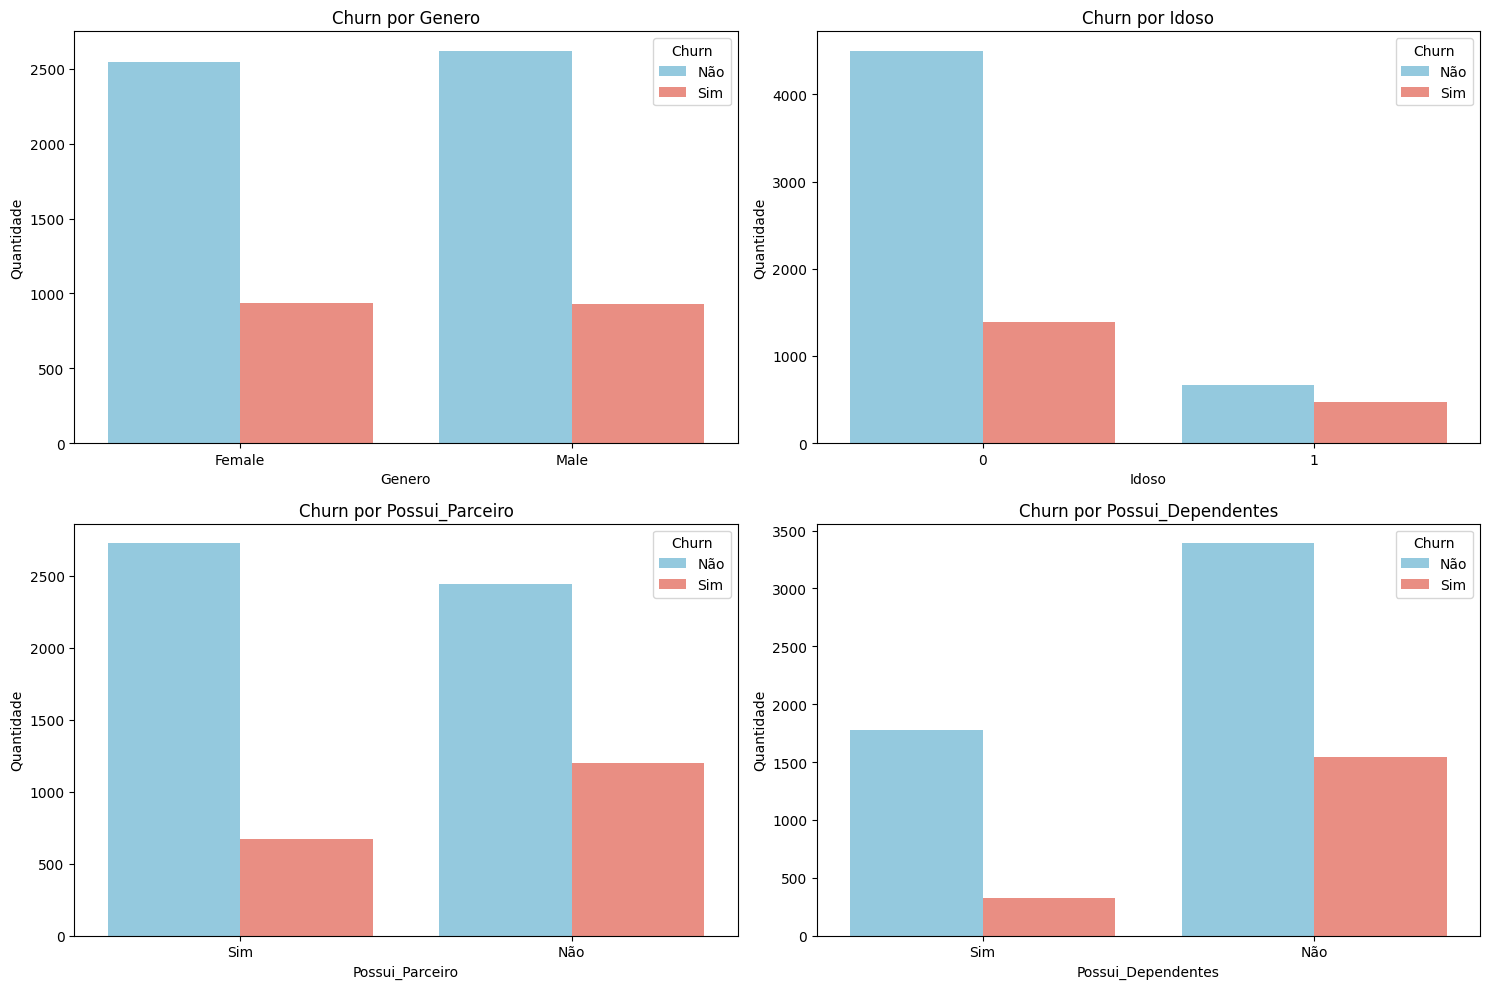

In [130]:
# Lista de colunas demográficas para analisar
variaveis_demograficas = ['Genero', 'Idoso', 'Possui_Parceiro', 'Possui_Dependentes']

# Tamanho da figura
plt.figure(figsize=(15, 10))

# Gerar um subplot para cada variável
for i, var in enumerate(variaveis_demograficas, 1):
    plt.subplot(2, 2, i)
    sns.countplot(
        data=df_padronizado,
        x=var,
        hue='Churn',
        palette={'Não': 'skyblue', 'Sim': 'salmon'}
    )
    plt.title(f'Churn por {var}')
    plt.xlabel(var)
    plt.ylabel('Quantidade')
    plt.legend(title='Churn')

plt.tight_layout()
plt.show()

##3.6. Análise do Churn por Variáveis Demográficas



1.  **Churn por Gênero**

---


A taxa de churn é praticamente igual entre homens e mulheres, o que indica que o gênero não tem uma influência significativa na decisão do cliente cancelar ou não o serviço. A diferença nas quantidades está alinhada com o tamanho das populações dos grupos, não havendo um destaque relevante.
2. **Churn por Idoso**


---
Nota-se que clientes que não são idosos (valor 0) apresentam uma quantidade maior de churn, mas isso também está relacionado ao fato de serem maioria na base de clientes.

Proporcionalmente, observa-se que idosos possuem uma taxa de churn proporcional ao grupo maior que a dos não-idosos, o que sugere que as pessoas de maior idade tendem a cancelar em maior proporção

3. **Churn por Possuir Parceiro**


---


Há uma diferença clara aqui. Clientes que não possuem parceiro apresentam uma taxa de churn mais alta. Isso sugere que quem tem parceiro (possivelmente uma estrutura familiar mais estável) é menos propenso a cancelar o serviço. Isso pode estar relacionado com maior estabilidade financeira ou maior dependência do serviço contratado dentro de uma residência compartilhada.




4. **Churn por Possuir Dependentes**

---
O comportamento é similar ao observado na variável "Possui Parceiro". Clientes que não possuem dependentes apresentam uma taxa de churn consideravelmente maior.

Aqueles com dependentes tendem a cancelar menos, reforçando a ideia de que uma estrutura familiar mais consolidada está associada a maior permanência no serviço. Pode estar relacionado ao fato de que famílias dependem mais do serviço, tornando o cancelamento uma decisão mais delicada.









<ipython-input-131-ef55a1f6a8ea>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_df, x='Taxa_Churn', y='Servico', palette='Reds_r')


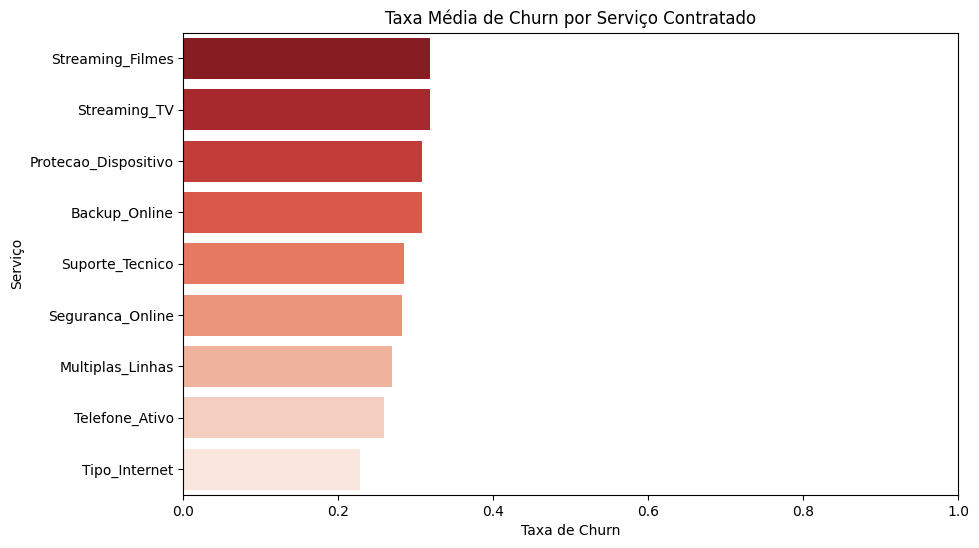

In [131]:
# Lista dos serviços na sua base
servicos = ['Tipo_Internet', 'Seguranca_Online', 'Backup_Online',
             'Protecao_Dispositivo', 'Suporte_Tecnico', 'Streaming_TV',
             'Streaming_Filmes', 'Telefone_Ativo', 'Multiplas_Linhas']

resultados = []

for servico in servicos:
    # Calcular a taxa de churn para cada categoria dentro do serviço
    temp = df_padronizado.groupby(servico)['Churn'].value_counts(normalize=True).unstack().fillna(0)
    if 'Sim' in temp.columns:
        churn_rate = temp['Sim'].mean()  # média da taxa de churn nas categorias do serviço
    else:
        churn_rate = 0  # se não tiver churn nessa categoria

    resultados.append({'Servico': servico, 'Taxa_Churn': churn_rate})

# Transformar em DataFrame
churn_df = pd.DataFrame(resultados).sort_values(by='Taxa_Churn', ascending=False)

# Plotar
plt.figure(figsize=(10,6))
sns.barplot(data=churn_df, x='Taxa_Churn', y='Servico', palette='Reds_r')
plt.title('Taxa Média de Churn por Serviço Contratado')
plt.xlabel('Taxa de Churn')
plt.ylabel('Serviço')
plt.xlim(0, 1)
plt.show()

## 3.7. Churn por Serviço Contratado
Apesar de curioso, o tipo de serviço contratado pelo cliente não parece ter influência com a taxa de Churn do mesmo.

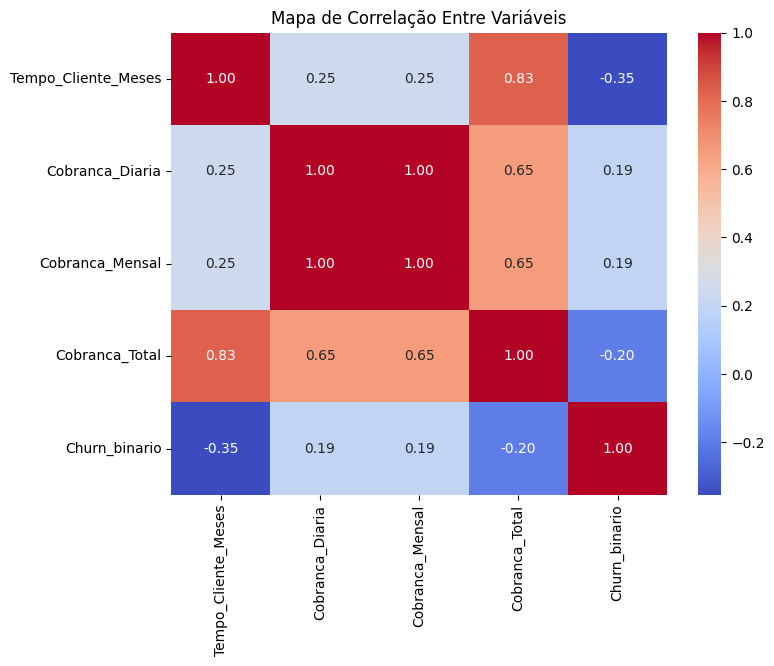

In [132]:
df_padronizado['Churn_binario'] = df_padronizado['Churn'].map({'Sim': 1, 'Não': 0})
variaveis = ['Tempo_Cliente_Meses', 'Cobranca_Diaria', 'Cobranca_Mensal', 'Cobranca_Total', 'Churn_binario']
corr = df_padronizado[variaveis].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação Entre Variáveis')
plt.show()

##4. Mapa de Correlação Entre Variáveis

Ao observar o mapa de correlação, podemos destacar alguns pontos importantes sobre o relacionamento entre as variáveis do nosso estudo:

A variável "Tempo de Cliente" apresenta uma correlação negativa moderada com o Churn (-0,35), indicando que quanto maior o tempo de permanência do cliente, menor a chance dele cancelar o serviço. Isso sugere que clientes mais antigos tendem a ser mais fiéis.

As variáveis "Cobrança Diária" e "Cobrança Mensal" possuem uma correlação perfeita (1.00), o que é esperado, já que ambas representam a mesma informação em períodos diferentes.

Existe uma correlação forte entre "Tempo de Cliente" e "Cobrança Total" (0,83), o que faz sentido, visto que a cobrança total é acumulativa e aumenta proporcionalmente ao tempo de permanência do cliente.

As cobranças, tanto diária quanto mensal, possuem uma correlação positiva leve com o Churn (0,19). Isso sugere que clientes que pagam valores mais altos mensalmente ou diariamente podem ter uma ligeira tendência maior ao cancelamento, possivelmente pela percepção de alto custo.

A "Cobrança Total" apresenta uma correlação negativa (-0,20) com o Churn, o que reforça a ideia de que clientes que já acumularam mais pagamentos ao longo do tempo são menos propensos ao cancelamento.

['ID_Cliente', 'Churn', 'Genero', 'Idoso', 'Possui_Parceiro',
       'Possui_Dependentes', 'Tempo_Cliente_Meses', 'Telefone_Ativo',
       'Multiplas_Linhas', 'Tipo_Internet', 'Seguranca_Online',
       'Backup_Online', 'Protecao_Dispositivo', 'Suporte_Tecnico',
       'Streaming_TV', 'Streaming_Filmes', 'Tipo_Contrato',
       'Fatura_Papel', 'Metodo_Pagamento', 'Cobranca_Diaria',
       'Cobranca_Mensal', 'Cobranca_Total']

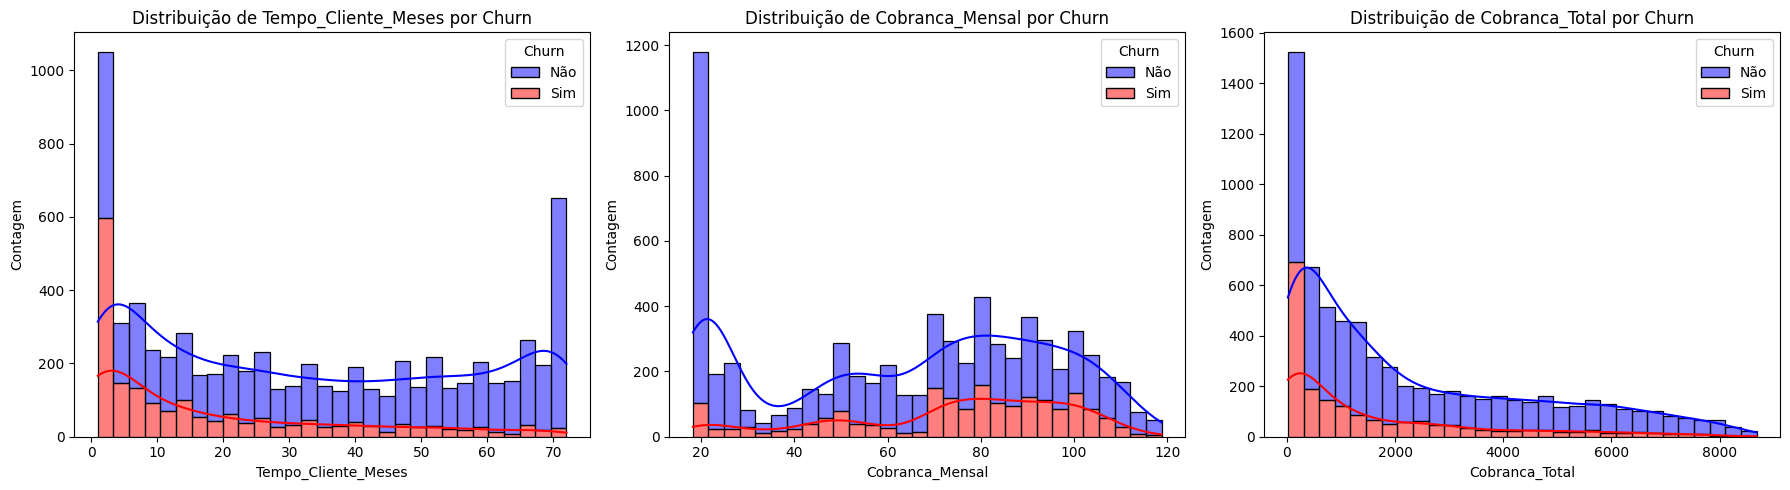

In [133]:
# Definindo as variáveis numéricas que vamos analisar
variaveis_numericas = ['Tempo_Cliente_Meses', 'Cobranca_Mensal', 'Cobranca_Total']

# Configura o tamanho dos gráficos
plt.figure(figsize=(18, 5))

# Loop para criar subplots
for i, var in enumerate(variaveis_numericas, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data=df_padronizado, x=var, hue='Churn', kde=True, bins=30, palette={'Não': 'blue', 'Sim': 'red'}, multiple='stack')
    plt.title(f'Distribuição de {var} por Churn')
    plt.xlabel(var)
    plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

<ipython-input-134-132effe56951>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_padronizado, x='Churn', y=var, palette={'Não': 'blue', 'Sim': 'red'})
<ipython-input-134-132effe56951>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_padronizado, x='Churn', y=var, palette={'Não': 'blue', 'Sim': 'red'})
<ipython-input-134-132effe56951>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_padronizado, x='Churn', y=var, palette={'Não': 'blue', 'Sim': 'red'})


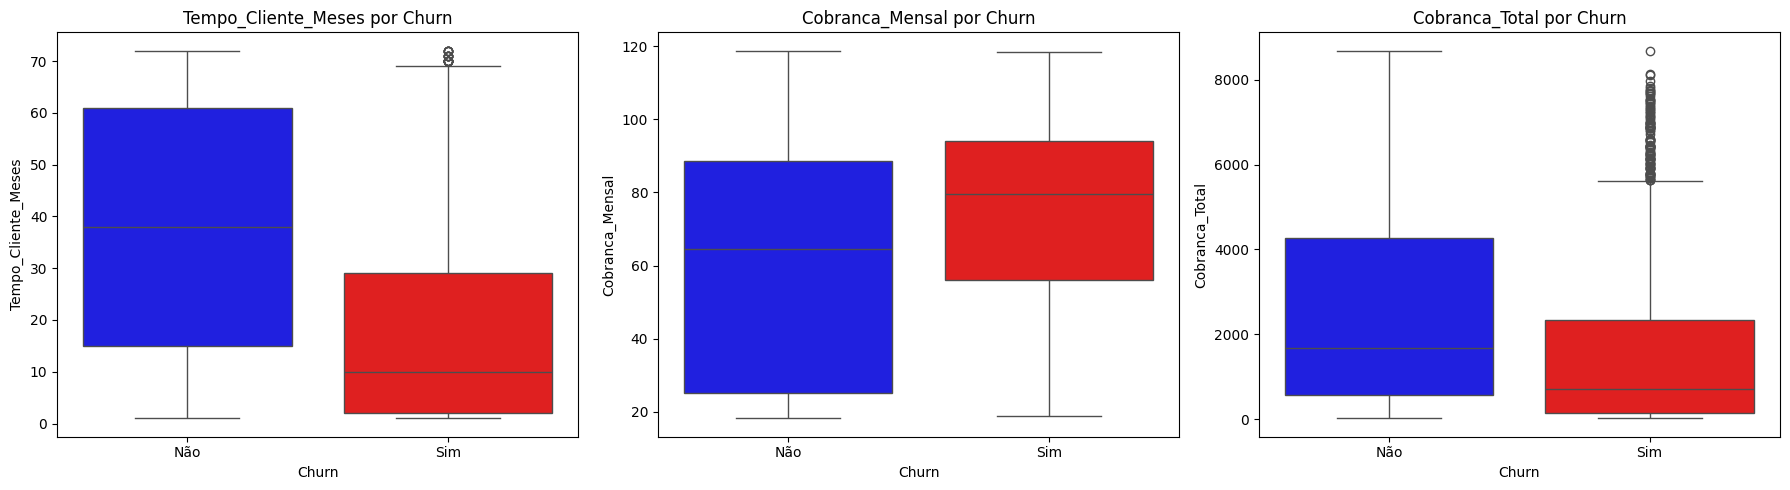

In [134]:
plt.figure(figsize=(18, 5))

for i, var in enumerate(variaveis_numericas, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df_padronizado, x='Churn', y=var, palette={'Não': 'blue', 'Sim': 'red'})
    plt.title(f'{var} por Churn')
    plt.xlabel('Churn')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

##5. Tempo de Cliente em Meses vs. Churn
**Distribuição**: Clientes que cancelaram (churn "Sim") tendem a ter um tempo de contrato muito curto, concentrando-se nos primeiros meses. Isso indica que boa parte da evasão ocorre logo no início do ciclo de vida do cliente.

Já os clientes que permaneceram (churn "Não") apresentam uma distribuição mais uniforme ao longo dos meses, com picos próximos de contratos longos (até 72 meses).

**Boxplot**: A mediana de tempo dos clientes que saem é significativamente mais baixa do que a dos clientes que permanecem. Isso reforça que clientes novos estão mais propensos ao churn.

##Cobranca Mensal vs. Churn
**Distribuição**: Clientes com churn tendem a ter cobranças mensais mais altas. O gráfico mostra uma concentração maior de churn em clientes cujas cobranças estão acima de 70 unidades monetárias.

Clientes que permanecem estão mais distribuídos, inclusive nas faixas mais baixas de cobrança mensal.

**Boxplot**: A mediana da cobrança mensal dos clientes que saem é mais alta do que dos clientes que ficam, indicando que custos mensais mais elevados podem estar associados à evasão.

##Cobranca Total vs. Churn
**Distribuição**: A cobrança total dos clientes que saem tende a ser mais baixa, o que faz sentido, já que eles ficam menos tempo na base. A maior parte deles não ultrapassa os 2000 unidades monetárias em cobrança total.

Quem permanece na base acumula valores bem mais altos, chegando até 8000 unidades ou mais, indicando longa permanência.

**Boxplot**: A mediana da cobrança total dos clientes que saem é visivelmente menor, e há uma maior concentração em valores baixos.

##O que observamos:
**Clientes que cancelam:**

* Geralmente têm pouco tempo de contrato.

* Possuem uma cobrança mensal mais alta.

* Consequentemente, acumulam uma cobrança total mais baixa, por ficarem pouco tempo na base.

**Clientes que ficam:**

* Estão associados a contratos de longo prazo.

* Possuem uma variedade maior de cobrança mensal, não sendo tão sensíveis a valores mais altos desde que o serviço atenda suas expectativas.

* Acumulam valores altos de cobrança total ao longo do tempo.

##6. Conclusão
Com base nas análises realizadas, identificamos padrões claros no comportamento dos clientes que cancelam seus contratos. A evasão está fortemente associada a dois fatores principais:

1. Clientes com pouco tempo de contrato, especialmente nos primeiros meses de relacionamento, apresentam taxas de churn significativamente mais altas. Isso demonstra que os clientes novos são mais suscetíveis a cancelar caso não percebam valor rapidamente no serviço oferecido.

2. Outro fator relevante é a cobrança mensal elevada, especialmente entre clientes que não utilizam métodos de pagamento automático. Clientes com custos mensais mais altos e pagamentos manuais tendem a apresentar maior propensão ao churn, possivelmente por maior percepção de custo ou menor comodidade no processo de pagamento.

Diante disso, podemos concluir que as melhores estratégias para reduzir a taxa de churn são:

* Focar em ações e promoções voltadas para os clientes recém-chegados, como benefícios nos primeiros meses, bônus de fidelidade ou experiências diferenciadas, buscando aumentar o engajamento e a percepção de valor desde o início do contrato.

* Incentivar fortemente o uso de métodos de pagamento automático, como débito em conta ou cartão, possivelmente oferecendo descontos, cashback ou outros benefícios para quem adotar essa modalidade. Isso não só melhora a conveniência do cliente, como também está associado a menores taxas de cancelamento.

Ao direcionar esforços nestes dois pontos — retenção de clientes novos e estímulo ao pagamento automático — a empresa terá um impacto significativo na redução da evasão e na melhoria da sustentabilidade financeira no longo prazo.

